In [1]:
from databaseCommunication import readDatabaseFile, createDataFrame_list
from dataframeFormating import createLabeledDataFrame_list #, N_polarized_pure3b, N_polarized, N_linear, getReducedDataframe, getReducedResults, 
from calculation import trapFrequency, getSubDF, noiseFilter, renameUnits, dropExcluded, computeBareTrapFrequencies, computeTrapFrequencies
from fit import fitDF, N_polarized_pure3b, N_polarized, N_linear, N_polarized_premix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from parameters import *

In [2]:
label_heads = ['isotope', 'run']


labels = [[['162', 'run1'], [181049, 181160]],  # look and remove a couple of shot under 34000 atom counts and below 1000ms hold
            [['162', 'run2'], [181193, 181304]],
            [['162', 'run3'], [181308, 181403]],
            [['162', 'run4'], [181567, 181662]],
            [['162', 'run5'], [181686, 181885]],
            [['162', 'run6'], [182117, 182212]],
            [['162', 'run7'], [182226, 182357]],
            [['162', 'run8'], [182393, 182481]],
            [['162', 'run9'], [182486, 182617]],
            [['162', 'run10'], [182618, 182749]],
            [['162', 'run11'], [182750, 182837]],
            #[['162', 'run12'], [182842, 182940]] This is a +3.75 that I screwed up by not changing the detuning
           [['162', 'run13'], [182967, 183038]]
             ] # July 2th

# All is with 162 isotope

# run1 : -11.25 GHz, low power. Weird atom number instability at the beginning, it could be because of TOF not being long enough (5ms)
# run2 : -20.25 GHz, low power. Longer TOF (7ms), now there seem to have 2 different decays
# run3 : -5.25 GHz (Attention, I screwed up and it was written -20.25 GHz). intermediate TOF (6ms). But seems to not decay at the begining, hence adding the
#                  secondary dataset with short time scale and large TOF to be sure to see the 3b decay.
# run4 : +5.25GHz, low power, long time. Forgot the images.
# run5 : +5.25GHz, high power, long time
# run6 : -5.25GHz, medium power, long time (less than 2 seconds)
# run7 : -5.25GHz, large power, long time (less than 200ms)
# run8 : -11.25GHz, medium power, long time (less than 10s)
# run9 : -11.25GHz, high power, long time (less than 5s)
# run10 : -20.25GHz, high power, long time (less than 1s)
# run11 : -20.25GHz, medium power, long time (less than 5s)
# run12 : +3.72GHz, medium power, long time (less than 5s)I realigned the pump in the middle which resulted in a lot more power at the end of the scan






labels_secondary = [[['162', 'run1'], [181405, 181444]],
                    [['162', 'run2'], [181445, 181484]],
                    [['162', 'run3'], [181485, 181524]],
                    [['162', 'run4'], [181525, 181564]],
                    [['162', 'run5'], [181890, 181944]],  # unsure about the end of this one
                    [['162', 'run6'], [181945, 182044]]
                   ] # July 2th
# run1 : -5.25GHz, small power , 8ms, short hold, to try to see a decay at the beginning
# run2 : -11.25Ghz, small power, 8ms
# run3 : -20.25GHz, small power, 8ms
# run4 : +5.25GHz, small power, 8ms
# run5 : +5.25GHz, high power, 8ms, maybe less necessary

compz_not_lossy = 7.4
compz_lossy = 7.83
compz_very_lossy = 7.85


excluded = [181097, 181198, 181332, 182212, 182704, 182771]

excluded_secondary = [181449, 181517]

Over the course of one experiment, the PD reading basically varies +/-3% at high power (when the baseline is around 1V).

In [3]:
PD_reading_df = pd.DataFrame({
    'latticeDepth_mW' : [0.3, 1, 5, 15, 50, 100, 160],
    'run1': [11.1, 17.6, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run2': [11.1, 17.4, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run3': [11.3, 18.0, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run4': [11.2, 17.9, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run5': [np.nan, np.nan, 60.1, 160, 514, 1030, 1632],
    'run6': [np.nan, np.nan, 57.2, 151, np.nan, np.nan, np.nan],
    'run7': [np.nan, np.nan, np.nan, np.nan, 498, 1000, 1630],
    'run8': [np.nan, np.nan, 60.8, 159.7, np.nan, np.nan, np.nan],
    'run9': [np.nan, np.nan, np.nan, np.nan, 528, 1075, 1697],
    'run10': [np.nan, np.nan, np.nan, np.nan, 530, 1070, 1730],
    'run11': [np.nan, np.nan, 58.8, 158.8, np.nan, np.nan, np.nan],
    #'run12': [np.nan, np.nan, np.nan, 158, 532, 1070, 1720],  # I realigned the pump in the middle which resulted in a lot more power at the end of the scan
    'run13': [np.nan, np.nan, np.nan, 163, np.nan, np.nan, 1757]
}
)

PD_reading_df_secondary = pd.DataFrame({
    'latticeDepth_mW' : [0.3, 1, 5, 15, 50, 100, 160],
    'run1': [11.3, 17.9, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run2': [11.2, 17.8, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run3': [11.2, 17.8, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run4': [11.2, 17.8, np.nan, np.nan, np.nan, np.nan, np.nan],
    'run5': [np.nan, np.nan, 59, 157, 514, 1010, 1625],
    'run6': [np.nan, np.nan, 59, 157, 514, 1010, 1625]  # I didn't check, just put the same as run5
}
)

In [4]:
PD_reading_df

,latticeDepth_mW,run1,run2,run3,run4,run5,run6,run7,run8,run9,run10,run11,run13
0,0.3,11.1,11.1,11.3,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,17.6,17.4,18.0,17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,60.1,57.2,NaN,60.8,NaN,NaN,58.8,NaN
3,15.0,NaN,NaN,NaN,NaN,160.0,151.0,NaN,159.7,NaN,NaN,158.8,163.0
4,50.0,NaN,NaN,NaN,NaN,514.0,NaN,498.0,NaN,528.0,530.0,NaN,NaN
5,100.0,NaN,NaN,NaN,NaN,1030.0,NaN,1000.0,NaN,1075.0,1070.0,NaN,NaN
6,160.0,NaN,NaN,NaN,NaN,1632.0,NaN,1630.0,NaN,1697.0,1730.0,NaN,1757.0


In [5]:
"""ciceroVariables = ['BECHoldTime', 'TOF', 'latticeDepth_final', 'latticeDetuning', 'compz_rotation', 'ODT3_Comp_final', 'ODT12_pre_lattice', 'ODT3_pre_lattice', 'dummy']
fitVariables = ['nCount', 'xWidth', 'yWidth', 'xPos', 'yPos']

df = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
df.to_pickle('data_save_210702_paper.pickle')

df_secondary = createLabeledDataFrame_list(labels_secondary, label_heads, ciceroVariables, fitVariables)
for column in df_secondary.columns:
    try:
        df_secondary[column] = df_secondary[column].astype(float)
    except:
        pass
df_secondary.to_pickle('data_save_210702_paper_secondary.pickle')"""

"ciceroVariables = ['BECHoldTime', 'TOF', 'latticeDepth_final', 'latticeDetuning', 'compz_rotation', 'ODT3_Comp_final', 'ODT12_pre_lattice', 'ODT3_pre_lattice', 'dummy']\nfitVariables = ['nCount', 'xWidth', 'yWidth', 'xPos', 'yPos']\n\ndf = createLabeledDataFrame_list(labels, label_heads, ciceroVariables, fitVariables)\nfor column in df.columns:\n    try:\n        df[column] = df[column].astype(float)\n    except:\n        pass\ndf.to_pickle('data_save_210702_paper.pickle')\n\ndf_secondary = createLabeledDataFrame_list(labels_secondary, label_heads, ciceroVariables, fitVariables)\nfor column in df_secondary.columns:\n    try:\n        df_secondary[column] = df_secondary[column].astype(float)\n    except:\n        pass\ndf_secondary.to_pickle('data_save_210702_paper_secondary.pickle')"

In [6]:
df = pd.read_pickle('data_save_210702_paper.pickle')
df_secondary = pd.read_pickle('data_save_210702_paper_secondary.pickle')


#df_TOF = df_TOF[df_TOF['imageID'] < 169640]

#### Noise filtering
#df_TOF = noiseFilter(df_TOF, nMax = np.inf, nMin = 4000, xWidthMax = np.inf, yWidthMax = 100)
#df_TOF =  noiseFilter(df_TOF, nMax = np.inf, nMin = 4000, xWidthMax = 100, xWidthMin = 4,  yWidthMax = 100, yWidthMin = 4)

#df_TOF =  noiseFilter(df_TOF, nMax = np.inf, nMin = 3000, xWidthMax = 100, xWidthMin = 3,  yWidthMax = 100, yWidthMin = 3)
#df_TOF =  noiseFilter(df_TOF, nMax = np.inf, nMin = 6000, xWidthMax = 300, xWidthMin = 3,  yWidthMax = 300, yWidthMin = 3)



# add units and renames columns
# it add xWidth_um and the inversion between X and Y is performed
renameUnits(df, magnification = 4.38, cameraPixelSize = 6.5, axis = 'horizontal', experiment = 'TOF')
renameUnits(df_secondary, magnification = 6.66, cameraPixelSize = 6.5, axis = 'vertical', experiment = 'inSitu')

# Delete these row indexes from dataFrame
dropExcluded(df, excluded)
dropExcluded(df_secondary, excluded_secondary)

wrongDetuningNames = pd.Index(np.where(df['imageID'].isin(list(range(181308, 181403+1))))[0])
df.iloc[wrongDetuningNames, 3] = -5.25

wrongDetuningNames = pd.Index(np.where(df['imageID'].isin(list(range(182842, 182940+1))))[0])
df.iloc[wrongDetuningNames, 3] = 3.75


In [7]:
computeBareTrapFrequencies(df)
#computeBareTrapFrequencies(df_inSitu, trapFrequency_x, trapFrequency_y, trapFrequency_z, trapFrequency_x_blue, trapFrequency_y_blue)

computeTrapFrequencies(df)
#computeTrapFrequencies(df_inSitu)

#temperature = 10*nK
#df_inSitu['rWidth_inSitu_v_um'] = np.sqrt(df_inSitu['xWidth_inSitu_v_um']*df_inSitu['yWidth_inSitu_v_um'])
#df_inSitu['rWidth_calculated_um'] = np.sqrt(k_B*temperature/(m*df_inSitu['trapFrequencyX_Hz']*df_inSitu['trapFrequencyY_Hz']))/um

In [8]:
getSubDF(df,['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], [-11.25, 160, 7.4]).head()

,BECHoldTime,TOF,latticeDepth_mW,latticeDetuning_GHz,compz,ODT3_Comp_final,ODT12_pre_lattice,ODT3_pre_lattice,dummy,nCount,...,run,xWidth_TOF_h_um,zWidth_TOF_h_um,trapFrequencyZ_kHz,deconfiningTrapFrequency_Hz,bareTrapFrequencyX_Hz,bareTrapFrequencyY_Hz,bareTrapFrequencyZ_Hz,trapFrequencyX_Hz,trapFrequencyY_Hz
0,10.0,5.0,160.0,-11.25,7.4,5.0,1.0,5.0,4.0,31415.0,...,run9,63.381084,46.355537,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131
1,0.0,5.0,160.0,-11.25,7.4,5.0,1.0,5.0,4.0,33901.0,...,run9,52.290868,45.992842,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131
2,2000.0,5.0,160.0,-11.25,7.4,5.0,1.0,5.0,4.0,15223.0,...,run9,74.931792,50.825103,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131
3,0.0,5.0,160.0,-11.25,7.4,5.0,1.0,5.0,4.0,28341.0,...,run9,54.751518,36.666084,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131
4,150.0,5.0,160.0,-11.25,7.4,5.0,1.0,5.0,3.0,25949.0,...,run9,62.563539,42.143893,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131


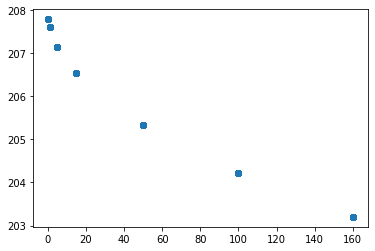

In [9]:
plt.figure()
df_temp = getSubDF(df, ['latticeDetuning_GHz'], [5.25])
plt.plot(df_temp['latticeDepth_mW'], df_temp['trapFrequencyY_Hz'], 'o')
plt.show()

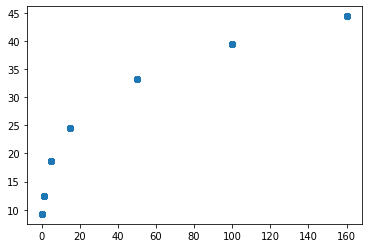

In [10]:
plt.figure()
df_temp = getSubDF(df, ['latticeDetuning_GHz'], [5.25])
plt.plot(df_temp['latticeDepth_mW'], df_temp['deconfiningTrapFrequency_Hz'], 'o')
plt.show()

I computed that for a blue lattice $\omega_\perp^2 = \frac{\hbar k\sqrt{2V_{741}}}{m^{3/2}w_{741}^2} = \frac{\hbar k\sqrt{2\frac{m\omega_z^2}{2k^2}}}{m^{3/2}w_{741}^2} = \frac{\hbar\omega_z}{m w_{741}^2}$.

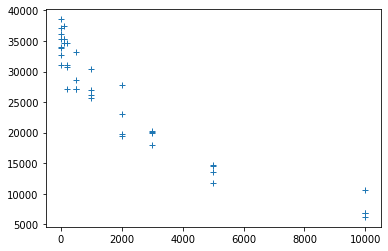

In [11]:
df_temp = getSubDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], [5.25, 160, compz_not_lossy])
plt.figure()
plt.plot(df_temp['BECHoldTime'], df_temp['nCount'], '+')
plt.show()

In [12]:
df.columns

Index(['BECHoldTime', 'TOF', 'latticeDepth_mW', 'latticeDetuning_GHz', 'compz',
       'ODT3_Comp_final', 'ODT12_pre_lattice', 'ODT3_pre_lattice', 'dummy',
       'nCount', 'xWidth', 'yWidth', 'xPos', 'yPos', 'imageID', 'isotope',
       'run', 'xWidth_TOF_h_um', 'zWidth_TOF_h_um', 'trapFrequencyZ_kHz',
       'deconfiningTrapFrequency_Hz', 'bareTrapFrequencyX_Hz',
       'bareTrapFrequencyY_Hz', 'bareTrapFrequencyZ_Hz', 'trapFrequencyX_Hz',
       'trapFrequencyY_Hz'],
      dtype='object')

In [13]:
latticeDepthList = np.sort(df['latticeDepth_mW'].unique())
BECHoldTimeList = np.sort(df['BECHoldTime'].unique())
latticeDetuningList = np.sort(df['latticeDetuning_GHz'].unique())
compzList = np.sort(df['compz'].unique())
ODT3_Comp_finalList = np.sort(df['ODT3_Comp_final'].unique())
trapFrequencyList = np.sort(df['trapFrequencyZ_kHz'].unique())


"""latticeDepthList = np.sort(df['latticeDepth'].unique())
BECHoldTimeList = np.sort(df['BECHoldTime'].unique())
latticeDetuningList = np.sort(df['latticeDetuning'].unique())
compzList = np.sort(df['compz'].unique())
ODTFactorList = np.sort(df['ODTFactor'].unique())"""
colors = ['red', 'blue', 'orange', 'black', 'green', 'pink', 'purple']

In [14]:
latticeDepthList

array([  0.3,   1. ,   5. ,  15. ,  50. , 100. , 160. ])

# Old stuff

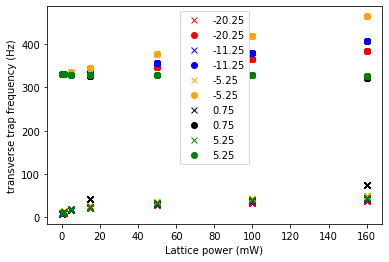

In [15]:
plt.figure()
i = 0
for latticeDetuning in latticeDetuningList:
    df_temp = getSubDF(df, ['latticeDetuning_GHz'], [latticeDetuning])
    plt.plot(df_temp['latticeDepth_mW'], df_temp['deconfiningTrapFrequency_Hz'], 'x', color = colors[i], label = latticeDetuning)
    plt.plot(df_temp['latticeDepth_mW'], df_temp['trapFrequencyX_Hz'], 'o', color = colors[i], label = latticeDetuning)
    i += 1
plt.legend()
plt.xlabel('Lattice power (mW)')
plt.ylabel('transverse trap frequency (Hz)')
plt.show()

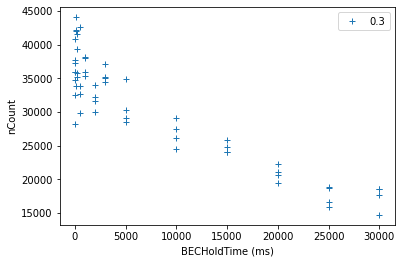

In [16]:
latticeDetuning = -11.25
compz = 7.4
plt.figure()
for latticeDepth in [0.3]:#, 20, 120]:
    df_temp = getSubDF(df, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])
    plt.plot(df_temp['BECHoldTime'], df_temp['nCount'], '+', label = str(round(latticeDepth, 2)))
plt.legend()
#plt.ylim(0, 5000)
#plt.ylim(0,50000)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

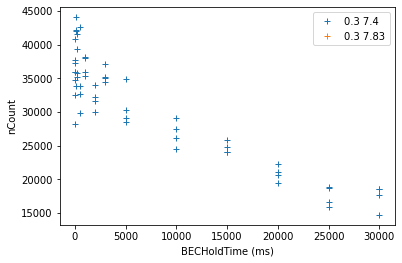

In [17]:
latticeDetuning = -11.25
plt.figure()
for latticeDepth in [0.3]:#, 20, 120]:
    df_temp_1 = getSubDF(df, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz_not_lossy])
    df_temp_2 = getSubDF(df, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz_lossy])
    plt.plot(df_temp_1['BECHoldTime'], df_temp_1['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' +str(compz_not_lossy))
    plt.plot(df_temp_2['BECHoldTime'], df_temp_2['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' +str(compz_lossy))
plt.legend()
#plt.ylim(0, 5000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

In [18]:
resultsDF_pure = fitDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], fitType = 'pure')
resultsDF_pure.drop(columns = ['BECHoldTime', 'xWidth', 'yWidth', 'imageID', 'dummy'], inplace = True)
resultsDF_pure['compz'] = resultsDF_pure['compz'].round(3)

resultsDF_pure_premix = fitDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], fitType = 'pure_premix')
resultsDF_pure_premix.drop(columns = ['BECHoldTime', 'xWidth', 'yWidth', 'imageID', 'dummy'], inplace = True)
resultsDF_pure_premix['compz'] = resultsDF_pure['compz'].round(3)

resultsDF_mix = fitDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], fitType = 'mix')
resultsDF_mix.drop(columns = ['BECHoldTime', 'xWidth', 'yWidth', 'imageID', 'dummy'], inplace = True)
resultsDF_mix['compz'] = resultsDF_mix['compz'].round(3)

resultsDF_lin = fitDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'compz'], fitType = 'lin', tmax_ms = np.inf)
resultsDF_lin.drop(columns = ['BECHoldTime', 'xWidth', 'yWidth', 'imageID', 'dummy'], inplace = True)
resultsDF_lin['compz'] = resultsDF_lin['compz'].round(3)






"""def N_polarized(t, N0, alpha, gamma):
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))

def N_linear(t, N0, b):
    return N0-b*t

def N_polarized_pure3b(t, N0, gamma):
    return N0 / np.sqrt(1+N0**2*gamma*t)"""


#print('\n')
#print(resultsDF)
#perr = np.sqrt(np.diag(pcov))

{'BECHoldTime': 7985.714285714285, 'TOF': 7.0, 'latticeDepth_mW': 0.3, 'latticeDetuning_GHz': -20.25, 'compz': 7.3999999999999995, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2.5, 'nCount': 27838.535714285714, 'xWidth': 34.962983928571425, 'yWidth': 36.56661607142857, 'xPos': 1084.2982142857143, 'yPos': 1398.54125, 'imageID': 181253.125, 'isotope': 162.0, 'xWidth_TOF_h_um': 51.88570674331377, 'zWidth_TOF_h_um': 54.265526133398566, 'trapFrequencyZ_kHz': 2.6258272685299207, 'deconfiningTrapFrequency_Hz': 7.737941330983325, 'bareTrapFrequencyX_Hz': 329.99999999999994, 'bareTrapFrequencyY_Hz': 208.00000000000003, 'bareTrapFrequencyZ_Hz': 235.0, 'trapFrequencyX_Hz': 330.1086909712889, 'trapFrequencyY_Hz': 208.17239935874755}
{'BECHoldTime': 7767.272727272727, 'TOF': 7.0, 'latticeDepth_mW': 1.0, 'latticeDetuning_GHz': -20.25, 'compz': 7.399999999999997, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2.50909090909090

{'BECHoldTime': 391.8181818181818, 'TOF': 5.0, 'latticeDepth_mW': 160.0, 'latticeDetuning_GHz': -11.25, 'compz': 7.399999999999998, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2.5, 'nCount': 27123.386363636364, 'xWidth': 42.539715909090916, 'yWidth': 29.757645454545454, 'xPos': 1082.360909090909, 'yPos': 1475.0506818181818, 'imageID': 182543.54545454544, 'isotope': 162.0, 'xWidth_TOF_h_um': 63.129715390203415, 'zWidth_TOF_h_um': 44.16088937318389, 'trapFrequencyZ_kHz': 74.27704492120104, 'deconfiningTrapFrequency_Hz': 41.15472122097777, 'bareTrapFrequencyX_Hz': 329.99999999999994, 'bareTrapFrequencyY_Hz': 208.00000000000003, 'bareTrapFrequencyZ_Hz': 235.0, 'trapFrequencyX_Hz': 407.8109552933756, 'trapFrequencyY_Hz': 317.2913097727319}
{'BECHoldTime': 4733.333333333333, 'TOF': 6.0, 'latticeDepth_mW': 0.3, 'latticeDetuning_GHz': -5.25, 'compz': 7.3999999999999995, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2

{'BECHoldTime': 2180.0, 'TOF': 6.0, 'latticeDepth_mW': 5.0, 'latticeDetuning_GHz': 5.25, 'compz': 7.4, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2.5, 'nCount': 29551.25, 'xWidth': 33.0814125, 'yWidth': 31.848360000000003, 'xPos': 1083.4515000000001, 'yPos': 1442.144, 'imageID': 181770.9, 'isotope': 162.0, 'xWidth_TOF_h_um': 49.09342037671233, 'zWidth_TOF_h_um': 47.263547945205474, 'trapFrequencyZ_kHz': 15.301828950690979, 'deconfiningTrapFrequency_Hz': 18.67944752131117, 'bareTrapFrequencyX_Hz': 329.99999999999994, 'bareTrapFrequencyY_Hz': 208.00000000000006, 'bareTrapFrequencyZ_Hz': 235.0, 'trapFrequencyX_Hz': 329.4709065157325, 'trapFrequencyY_Hz': 207.1595477893756}
{'BECHoldTime': 2180.0, 'TOF': 6.0, 'latticeDepth_mW': 15.0, 'latticeDetuning_GHz': 5.25, 'compz': 7.4, 'ODT3_Comp_final': 5.0, 'ODT12_pre_lattice': 1.0, 'ODT3_pre_lattice': 5.0, 'dummy': 2.5, 'nCount': 27505.925, 'xWidth': 35.2469825, 'yWidth': 25.637872499999997, 'xPos': 1082.5

'def N_polarized(t, N0, alpha, gamma):\n    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))\n\ndef N_linear(t, N0, b):\n    return N0-b*t\n\ndef N_polarized_pure3b(t, N0, gamma):\n    return N0 / np.sqrt(1+N0**2*gamma*t)'

In [19]:
resultsDF_pure_premix

,N0,alpha,gamma,b,TOF,latticeDepth_mW,latticeDetuning_GHz,compz,ODT3_Comp_final,ODT12_pre_lattice,...,isotope,xWidth_TOF_h_um,zWidth_TOF_h_um,trapFrequencyZ_kHz,deconfiningTrapFrequency_Hz,bareTrapFrequencyX_Hz,bareTrapFrequencyY_Hz,bareTrapFrequencyZ_Hz,trapFrequencyX_Hz,trapFrequencyY_Hz
0,33120.504473,0.000031,-7.596273e-15,NaN,7.0,0.3,-20.25,7.4,5.0,1.0,...,162.0,51.885707,54.265526,2.625827,7.737941,330.0,208.0,235.0,330.108691,208.172399
1,33398.726218,0.000031,-7.064580e-15,NaN,7.0,1.0,-20.25,7.4,5.0,1.0,...,162.0,51.410494,55.290280,4.794083,10.455508,330.0,208.0,235.0,330.362164,208.574110
2,37618.426251,0.000031,3.517360e-14,NaN,5.0,5.0,-20.25,7.4,5.0,1.0,...,162.0,39.085635,38.580913,10.719895,15.634630,330.0,208.0,235.0,331.806868,210.854921
3,37400.461683,0.000031,5.275390e-14,NaN,5.0,15.0,-20.25,7.4,5.0,1.0,...,162.0,41.473218,38.382169,18.567403,20.576331,330.0,208.0,235.0,335.391402,216.451825
4,36766.727700,0.000031,5.177582e-14,NaN,5.0,50.0,-20.25,7.4,5.0,1.0,...,162.0,45.299834,37.022332,33.899284,27.802741,330.0,208.0,235.0,347.646337,234.993565
5,37151.532601,0.000031,1.371995e-13,NaN,5.0,100.0,-20.25,7.4,5.0,1.0,...,162.0,51.229805,34.861016,47.940828,33.063218,330.0,208.0,235.0,364.439229,259.190956
6,37549.753391,0.000031,3.124183e-13,NaN,5.0,160.0,-20.25,7.4,5.0,1.0,...,162.0,57.729386,39.416817,60.640883,37.185628,330.0,208.0,235.0,383.621588,285.533750
7,36695.563261,0.000031,-3.803214e-15,NaN,5.0,0.3,-11.25,7.4,5.0,1.0,...,162.0,37.886573,37.632146,3.216290,8.563868,330.0,208.0,235.0,330.163056,208.258597
8,37767.338433,0.000031,1.303154e-14,NaN,5.0,1.0,-11.25,7.4,5.0,1.0,...,162.0,39.307381,39.438916,5.872116,11.571500,330.0,208.0,235.0,330.543206,208.860746
9,35847.959349,0.000031,7.179132e-14,NaN,6.0,5.0,-11.25,7.4,5.0,1.0,...,162.0,46.912030,46.610557,13.130451,17.303429,330.0,208.0,235.0,332.707162,212.268828


In [20]:
latticeDepth = 1
latticeDetuning = -11.25
compz = compz_not_lossy
df_tempZ = getSubDF(df, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])
time = np.linspace(0, 3000, 10000)

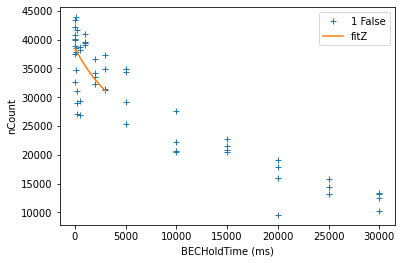

In [21]:
resultZ = getSubDF(resultsDF_pure, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])

NZ, gammaZ = resultZ[['N0', 'gamma']].iloc[0,:]
Z = N_polarized_pure3b(time, NZ, gammaZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

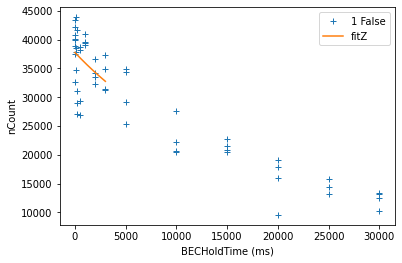

In [22]:
resultZ = getSubDF(resultsDF_pure_premix, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])

NZ, gammaZ = resultZ[['N0', 'gamma']].iloc[0,:]
Z = N_polarized_premix(time, NZ, gammaZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0, 20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

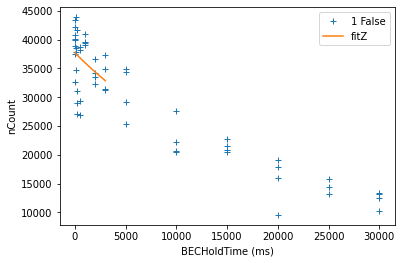

In [23]:
resultZ = getSubDF(resultsDF_mix, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])

NZ, alphaZ, gammaZ = resultZ[['N0', 'alpha', 'gamma']].iloc[0,:]

Z = N_polarized(time, NZ, alphaZ, gammaZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0,20000)
#plt.xlim(0,10)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

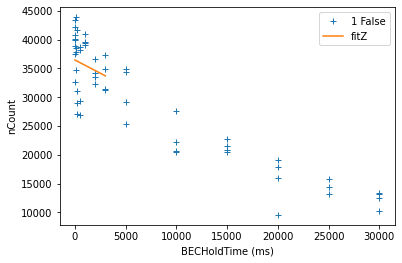

In [24]:
resultZ = getSubDF(resultsDF_lin, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])

NZ, bZ = resultZ[['N0', 'b']].iloc[0,:]

Z = N_linear(time, NZ, bZ)

plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(round(latticeDepth, 2)) + ' ' + str(False))
plt.plot(time, Z, '-', label = 'fitZ')
plt.legend()
#plt.ylim(0,30000)
#plt.xlim(0,100)
plt.xlabel('BECHoldTime (ms)')
plt.ylabel('nCount')
plt.show()

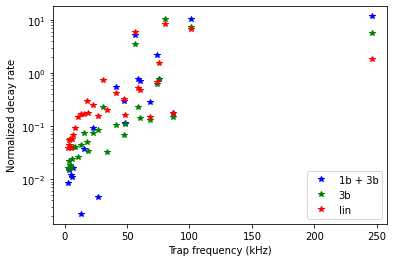

In [25]:
resultsDF_notLossy = getSubDF(resultsDF_mix, ['compz'], [compz])
resultsDF_notLossy_pure = getSubDF(resultsDF_pure, ['compz'], [compz])
resultsDF_notLossy_lin = getSubDF(resultsDF_lin, ['compz'], [compz])

#latticePower = -resultsDF_Z['latticeDepth']/resultsDF_Z['latticeDetuning']
trapFrequencyList = resultsDF_notLossy['trapFrequencyZ_kHz']
decay_1b3b = resultsDF_notLossy['gamma']/resultsDF_notLossy['gamma'].mean()
decay_3b = resultsDF_notLossy_pure['gamma']/resultsDF_notLossy_pure['gamma'].mean()
decay_lin = resultsDF_notLossy_lin['b']/resultsDF_notLossy_lin['b'].mean()

plt.figure()
plt.semilogy(trapFrequencyList, decay_1b3b, 'b*', label = '1b + 3b')
plt.semilogy(trapFrequencyList, decay_3b, 'g*', label = '3b')
plt.semilogy(trapFrequencyList, decay_lin, 'r*', label = 'lin')
plt.xlabel("Trap frequency (kHz)")
plt.ylabel("Normalized decay rate")


plt.legend()
#plt.ylim(0,0.2*10**(-11))
plt.show()

The increase in power should result in a smaller cloud. The density is proportional to $n\sim 1/(a_{oh}r_{\perp}^{2}) \sim \sqrt{\omega_{z}}\frac{\omega_{\perp}^{2}}{\mu}$. Assuming the chemical potential constant, the density $n$ goes like $(P/\Delta)^{5/4}$. In that case the decay coefficient which is proportional to $n^{2}$ should be scalled accordingly.
If we rather fix the scattering length $a$ and write $\mu\sim na$ then at constant $a$ it gives $n \sim (P/\Delta)^{5/8})$.

And $P/\Delta \propto \omega_{z}^{2}$

Note for a thermal cloud that gets compressed from $\omega_i$ to $\omega_f = k\omega_i$. $E_i = \sum \epsilon_i p_i$ and $E_f = \sum \epsilon_f p_f = \sum (k\epsilon_i) p_i = kE_i$. So the temperature goes like $T_f = kT_i$. But the probability to occupy each state remains the same, so $\omega^2 \Delta x^2/T = $ cste. There for $\Delta x_f = \Delta x_i/\sqrt{k}$. So a good proxy for the density is $n \propto 1/(a_z r^2) \propto \omega_z^{1/2} \sqrt{k}^{2} \propto \omega_z^{3/2}$. Or if we want to be more precise and take into consideration the ODT trapping, one should say $n \propto \omega_z^{1/2}\omega_{\perp,1}^{1/2}\omega_{\perp,2}^{1/2}$

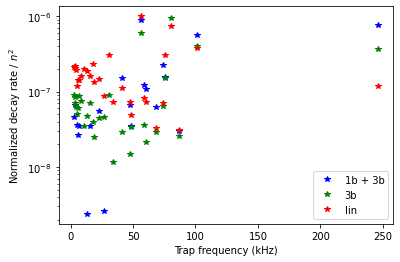

In [26]:
powerExponent = 3/2
# 3/2 for 2D thermal + 1D HO
# 5/2 for 2D BEC fixed chemical potential (wrong) + 1D HO
# 5/4 for 2D BEC fixed scattering length + 1D HO

trapFrequencyList = resultsDF_notLossy['trapFrequencyZ_kHz']
decay_1b3b = resultsDF_notLossy['gamma']/resultsDF_notLossy['gamma'].mean()/(trapFrequencyList**2)**(powerExponent)
decay_3b = resultsDF_notLossy_pure['gamma']/resultsDF_notLossy_pure['gamma'].mean()/(trapFrequencyList**2)**(powerExponent)
decay_lin = resultsDF_notLossy_lin['b']/resultsDF_notLossy_lin['b'].mean()/(trapFrequencyList**2)**(powerExponent)
### That was the previous scaling before we changed to take into account the ODT trapping

### Now it is simple n^2 \propto omega_z * omega_perp1^2 * omega_perp2^2
trapFrequencyList = resultsDF_notLossy['trapFrequencyZ_kHz']
trapFrequencyPerp1List = resultsDF_notLossy['trapFrequencyX_Hz']
trapFrequencyPerp2List = resultsDF_notLossy['trapFrequencyY_Hz']
decay_1b3b = resultsDF_notLossy['gamma']/resultsDF_notLossy['gamma'].mean()/(trapFrequencyList*trapFrequencyPerp1List*trapFrequencyPerp2List)
decay_3b = resultsDF_notLossy_pure['gamma']/resultsDF_notLossy_pure['gamma'].mean()/(trapFrequencyList*trapFrequencyPerp1List*trapFrequencyPerp2List)
decay_lin = resultsDF_notLossy_lin['b']/resultsDF_notLossy_lin['b'].mean()/(trapFrequencyList*trapFrequencyPerp1List*trapFrequencyPerp2List)


plt.figure()
plt.semilogy(trapFrequencyList, decay_1b3b, 'b*', label = '1b + 3b')
plt.semilogy(trapFrequencyList, decay_3b, 'g*', label = '3b')
plt.semilogy(trapFrequencyList, decay_lin, 'r*', label = 'lin')

plt.xlabel("Trap frequency (kHz)")
plt.ylabel("Normalized decay rate / $n^2$")
plt.legend()
#plt.ylim(0,0.2*10**(-11))
plt.show()

Let's use only the pure 3b fit

In [27]:
#results = resultsDF_pure_premix
results = resultsDF_pure
#results = resultsDF_lin

In [28]:
latticeDepthList = np.sort(df['latticeDepth_mW'].unique())
BECHoldTimeList = np.sort(df['BECHoldTime'].unique())
latticeDetuningList = np.sort(df['latticeDetuning_GHz'].unique())
compzList = np.sort(df['compz'].unique())

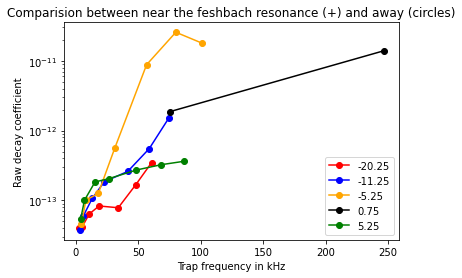

In [29]:
plt.figure()
i = 0
for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['gamma'], color = colors[i], marker = 'o', label = latticeDetuning)
    plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['gamma'], color = colors[i], marker = '+')
    i += 1
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel('Raw decay coefficient')
plt.title('Comparision between near the feshbach resonance (+) and away (circles)')
plt.show()

The average xWidth of the cloud is 4.36 pixel and yWidth is 4.45, each are 6.5 micro meters big and magnification is 4. It makes 7 micrometers cloud size (one sigma), so approximately 40 pancakes filled.

The nCount of the previous data was accounting a 3.45 micro meters pixel and 1 magnification, this should be corrected accordingly

For the temperature : $\sigma = \sqrt{\sigma_0^{2}+(\sigma_v\tau)^2}$ with $\sigma_{0} = 7 \mu m$ and $\tau$ the time of flight. And $\sigma_{v} = \sqrt{\frac{k_{B}T}{m}}$ so $T = \frac{m}{k_{B}}\frac{\sigma^2-\sigma^2_0}{\tau^2}$

In [30]:
23.4008*pixel_size/magnification

3.4727214611872146e-05

In [31]:
pixel_size

6.5e-06

In [67]:
m_Dy*(29*pixel_size/magnification/(5*tof_unit))**2/k_B*10**9

1461.5286363406983

In [64]:
getSubDF(df, ['latticeDetuning_GHz', 'latticeDepth_mW', 'BECHoldTime'], [-11.25, 160, 0]).iloc[:,10:]

,xWidth,yWidth,xPos,yPos,imageID,isotope,run,xWidth_TOF_h_um,zWidth_TOF_h_um,trapFrequencyZ_kHz,deconfiningTrapFrequency_Hz,bareTrapFrequencyX_Hz,bareTrapFrequencyY_Hz,bareTrapFrequencyZ_Hz,trapFrequencyX_Hz,trapFrequencyY_Hz,temperature_nK
0,35.2360,30.9921,1084.91,1477.78,182491.0,162.0,run9,52.290868,45.992842,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2156.420449
1,36.8941,24.7073,1082.19,1471.91,182493.0,162.0,run9,54.751518,36.666084,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2364.144840
2,36.6910,26.9860,1080.12,1474.02,182514.0,162.0,run9,54.450114,40.047717,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2338.187508
3,39.2986,31.3446,1084.56,1476.43,182535.0,162.0,run9,58.319840,46.515959,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2682.343527
4,37.2556,27.3521,1083.19,1474.24,182579.0,162.0,run9,55.287991,40.591016,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2410.701084
5,35.7779,29.2045,1083.64,1474.60,182585.0,162.0,run9,53.095057,43.340011,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2223.258343
6,34.7369,28.6064,1080.99,1474.63,182613.0,162.0,run9,51.550194,42.452420,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2095.763903
7,37.1790,31.4468,1080.61,1477.28,182617.0,162.0,run9,55.174315,46.667626,74.277045,41.154721,330.0,208.0,235.0,407.810955,317.29131,2400.798150


In [32]:
#sigma_0_um = 7
sigma_0_um = 0

#df['temperature'] = (m/k_B*((df['xWidth_TOF_h_um']*um)**2-(df['xWidth_inSitu_v_um']*um)**2)/((df['TOF']*ms)**2))/nK # in nano kelvin
# if you use xWidth_inSitu_v_um there is nothing for red detuned runs

df['temperature_nK'] = (m/k_B*((df['xWidth_TOF_h_um']*um)**2-(sigma_0_um*um)**2)/((df['TOF']*ms)**2))/nK # in nano kelvin
df[['xWidth', 'xWidth_TOF_h_um','temperature_nK']]

,xWidth,xWidth_TOF_h_um,temperature_nK
0,22.9493,34.057180,914.743065
1,26.9596,40.008539,1262.371344
2,23.9815,35.588984,998.879101
3,23.4008,34.727215,951.090073
4,31.5434,46.810982,1728.133326
...,...,...,...
1352,33.4109,49.582386,3029.399951
1353,32.5854,48.357329,2881.551448
1354,31.4307,46.643733,2680.947885
1355,31.8607,47.281861,2754.805184


In [33]:
df_temperature = df.groupby(['latticeDetuning_GHz', 'BECHoldTime', 'latticeDepth_mW', 'compz']).mean().reset_index()
df_initial_temperature = getSubDF(df_temperature, ['BECHoldTime'], [0]).groupby(['latticeDetuning_GHz', 'latticeDepth_mW', 'compz']).mean().reset_index()

In [34]:
results = pd.merge(results, df_initial_temperature, how="outer", on=["latticeDetuning_GHz", "latticeDepth_mW", 'compz'], suffixes=('', '_y'))#, validate="many_to_many")
results.drop(results.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

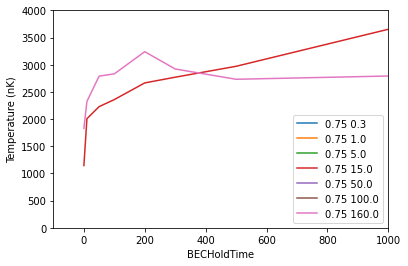

In [35]:
compz = compz_not_lossy
plt.figure()
for latticeDetuning in latticeDetuningList[3:4]:
    for latticeDepth in latticeDepthList:
        df_temp = getSubDF(df_temperature, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])
        plt.plot(df_temp['BECHoldTime'], df_temp['temperature_nK'], label = str(latticeDetuning)+ " " + str(latticeDepth) )
plt.ylim(0,4000)
plt.xlim(-100,1000)
plt.legend()
plt.xlabel('BECHoldTime')
plt.ylabel('Temperature (nK)')
plt.show()

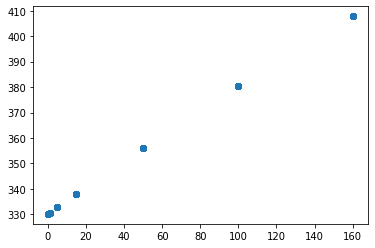

In [36]:
latticeDetuning = -11.25
df_temp = getSubDF(df, ['latticeDetuning_GHz'], [latticeDetuning])
plt.figure()
plt.plot(df_temp['latticeDepth_mW'], df_temp['trapFrequencyX_Hz'], 'o')
plt.show()

In [37]:
beamwaist

5.2e-05

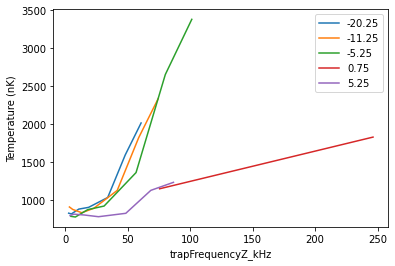

In [38]:
compz = compz_not_lossy
plt.figure()
for latticeDetuning in latticeDetuningList:
    df_temp = getSubDF(df_initial_temperature, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz])
    plt.plot(df_temp['trapFrequencyZ_kHz'], df_temp['temperature_nK'], label = latticeDetuning)
#plt.ylim(0,1000)
#plt.xlim(0,100)
plt.legend()
plt.xlabel('trapFrequencyZ_kHz')
plt.ylabel('Temperature (nK)')
plt.show()

The density is $N/V \simeq N/(2a_z(2a_{\perp})^2) = N/\left(8\sqrt{\hbar/(m\omega_z)}\sqrt{k_B T/m\omega_\perp^2}^{2}\right) = \frac{N m^{3/2}\omega_z^{1/2}\omega_\perp}{8\hbar^{1/2} k_B T} = \frac{N m^{3/2}\omega_z^{5/2}}{8A^2\hbar^{1/2} k_B T}$ with $A = \omega_z / \omega_\perp$ the aspect ratio (A = 162)

More precise calculation would be $P(r,z) = K e^{-\frac{z^2}{2a_z^{2}}} e^{-\frac{\frac{1}{2}m\omega_\perp^2 r^{2}}{k_B T}}$ and normalization condition gives for the N-particle 3D density probability $n(r,z) = \frac{N m \omega_\perp^{2}}{\pi^{3/2}\sqrt{2}a_z k_B T} e^{-\frac{z^2}{2a_z^{2}}} e^{-\frac{\frac{1}{2}m\omega_\perp^2 r^{2}}{k_B T}} = \frac{N m^{3/2} \omega_z^{5/2}}{\pi^{3/2}\sqrt{2}\hbar^{1/2}A^{2} k_B T} e^{-\frac{z^2}{2a_z^{2}}} e^{-\frac{\frac{1}{2}m\omega_\perp^2 r^{2}}{k_B T}}$. And we have $\pi^{3/2}\sqrt{2} = 7.87 \simeq 8$.

Eventually we changed this analysis to take into account the ODT trapping potential and we are keeping $n(r,z) = \frac{N m \omega_\perp^{2}}{\pi^{3/2}\sqrt{2}a_z k_B T} e^{-\frac{z^2}{2a_z^{2}}} e^{-\frac{\frac{1}{2}m\omega_\perp^2 r^{2}}{k_B T}} = \frac{N m^{3/2}\omega_z^{1/2} \omega_\perp^{2}}{\pi^{3/2}\sqrt{2}\hbar^{1/2} k_B T} e^{-\frac{z^2}{2a_z^{2}}} e^{-\frac{\frac{1}{2}m\omega_\perp^2 r^{2}}{k_B T}}$

Note that here the dependance looks to be like $\omega_z^{5/2}$ but there is a dependance hidden in the temperature that should go up like $\omega$, starting from 90-200 Hz in the ODT, up to 2 kHz in the deepest lattice, so there should be a factor of 10 there.

Now we can put units on the 3-body coefficient. WRONG: From the fit we get $\gamma = \beta<n^2>$. And the time unit of the fit is ms.
I keep the mistake here because it caused me some trouble. The real expression is $\beta = \gamma V^2$. Indeed $\frac{dN}{dt} = -\gamma N^3$ for the fit and $\frac{dN}{dt} = -\beta<n^2>N = -\beta/V^2 N^3$. Volume here is understood as the volume of all the pancakes combined.

# Notes from the BEC Calculation


## Temperature and trap frequency

### In BEC

In the BEC the density is like $n(x, y, z) = K e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = N\omega_x\omega_y\omega_z\left(\frac{m}{2\pi k_B T}\right)^{3/2} e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}} = n_0 e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2 + \omega_z^2 z^2)}{k_B T}}$

By definition $<n^2> = \int n^2p(x, y, z)d\tau = \frac{1}{N}\int n^3 d\tau = N^2 (\omega_x\omega_y\omega_z)^2\frac{1}{\sqrt{27}}\left(\frac{m}{2\pi k_B T}\right)^3 = \frac{N^2}{\sqrt{27}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$. The differential equation formula is: $\frac{dN}{dt} = -\gamma N^3$ in the fit, but $\frac{dN}{dt} = -\beta <n^2> N$ in reality, so $\frac{dN}{dt} = -\beta \frac{N^2}{\alpha} N$ with $\alpha = 3^{3/2}\left(\frac{2\pi k_B T}{m}\right)^3\frac{1}{(\omega_x\omega_y\omega_z)^2} = 3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2 = \frac{3^{3/2}}{(n_0/N)^2}$, so $\beta = \gamma\alpha$

### In the lattice

Note: I should use the full calculation of the gaussian wavepacket, in the mean time I can define a fake $\frac{1}{\bar a_z} = \frac{1}{\lambda /2\sqrt{2\pi}} + \frac{1}{a_z}$.
Indeed, for deep lattices, the density is $n(x, y, z) = n_0 e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2)}{k_B T}}e^{-\frac{z^2}{2a_z^2}}$ and therefore $\boxed{n_0 = \frac{Nm\omega_x\omega_y}{(2\pi)^{3/2}k_B T a_z} = \frac{Nm^{3/2}\omega_x\omega_y\omega_z^{1/2}}{(2\pi)^{3/2}k_B T \sqrt{\hbar}}}$ but in the case of a very weak lattice $a_z$ should saturate to a fixed value. Write the 3D density $n(x, y, z) = n_0 e^{-\frac{\frac{1}{2}m(\omega_x^2 x^2 + \omega_y^2 y^2)}{k_B T}}$ and integrate it on one lattice site $z = -\lambda/4 .. \lambda /4$ gives that $\frac{\lambda}{2} = \sqrt{2\pi a_{z,saturated}^2}$. A good interpolation would be $\frac{1}{\bar a_z} = \frac{1}{\lambda /2\sqrt{2\pi}} + \frac{1}{a_z}$. And it leads to the effective $\bar \omega_z = \left( \sqrt{\omega_z} + \frac{2\sqrt{2\pi}}{\lambda}\sqrt{\frac{\hbar}{m}}\right)^2 = \left( \sqrt{\omega_z} + \frac{2}{\sqrt{\pi}}\sqrt{\frac{E_r}{\hbar}}\right)^2$. The correction at $\omega_z = 0$ is about 2.8 kHz.

Then we again have $<n^2> = n_0^2/\sqrt{27}$ and the local differential equation is $\frac{dn}{dt} = -\beta n^2 n$ which integrated over the volume gives$\int_V \frac{dn}{dt} = \frac{dN}{dt} = -\int_V \beta n^2 n d\tau = -\int_V \beta n^2 Np(\tau) d\tau = -\beta <n(t)^2>N = -\beta\frac{n_0^2\left(\frac{N(t)}{N_0}\right)^2}{\sqrt{27}}N$. So eventually $\boxed{\frac{dN}{dt} =-\beta\frac{n_0^2}{N_0^2\sqrt{27}}N^3} = -\gamma N^3$

## In situ measurement

Other way to calculate the volume, simply use the in situ imaging with the density being $N/V \simeq N/(2a_x 2a_y 2a_z)^2) = \frac{N}{8(7\mu m 7.3\mu m 18\mu m)}$. Actually more precise calculation gives: $n = \frac{N}{(2\pi)^{3/2}\sigma_x\sigma_y\sigma_z}e^{-\frac{1}{2}(\frac{x^2}{\sigma_x^2}+\frac{y^2}{\sigma_y^2}+\frac{z^2}{\sigma_z^2})}$ and therefore $<n^2> = \frac{1}{N}\int n^3 d\tau = \frac{N^2}{3^{3/2}(2\pi)^3(\sigma_x\sigma_y\sigma_z)^2}$.

In [39]:
def effectiveOmegaZ(omega):
    return (np.sqrt(omega)+2*np.sqrt(2*np.pi*hbar/m)/(741*nm))**2

results['effectiveTrapFrequencyZ_kHz'] = effectiveOmegaZ(results['trapFrequencyZ_kHz']*kHz)/kHz

In [40]:
#numberOfPancakes_fromBEC = 40 # for ODT Prefactor of 1
#numberOfPancakes = numberOfPancakes_fromBEC/np.sqrt(np.maximum(results['ODTFactor'], 1))
numberOfPancakes = 24


temperature_nK = 600
prefactor = (m/(2*np.pi))**(3/2)/(k_B*np.sqrt(hbar))
# I assume here 400 nK, but eventually we should do a proper thermometry of the initial cloud.

#results['density'] = results['N0']/numberOfPancakes*prefactor*(2*np.pi*results['trapFrequency']*10**3)**(5/2)/(temperature_nK*10**(-9))*10**(-6)  # in atoms / cm3
trapFrequenciesProduct = (results['effectiveTrapFrequencyZ_kHz']*kHz)**(1/2)*results['trapFrequencyX_Hz']*Hz*results['trapFrequencyY_Hz']*Hz

# MODIFY THE NUMBER OF PANCAKES HERE
results['density_constantT'] = results['N0']/numberOfPancakes*prefactor/(temperature_nK*nK)*trapFrequenciesProduct*cm3  # in atoms / cm3

In [41]:
results['beta_constantT'] = results['gamma']/ms  * results['N0']**2 * np.sqrt(27) / results['density_constantT']**2 # this is is cm^6/s

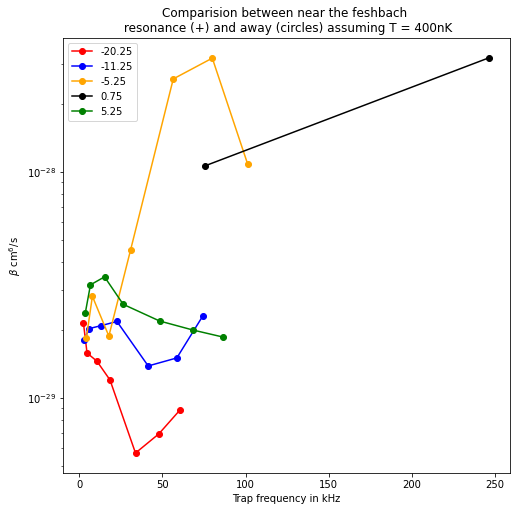

In [42]:
plt.figure(figsize = (8, 8))
i = 0
for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['beta_constantT'], color = colors[i], marker = 'o', label = latticeDetuning)
    plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['beta_constantT'], color = colors[i], marker = '+')
    i += 1
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel(r'$\beta$ cm$^6/$s')
plt.title('Comparision between near the feshbach \n resonance (+) and away (circles) assuming T = 400nK')
plt.savefig('beta_coef.jpg', dpi = 300, transparent = False)
plt.show()

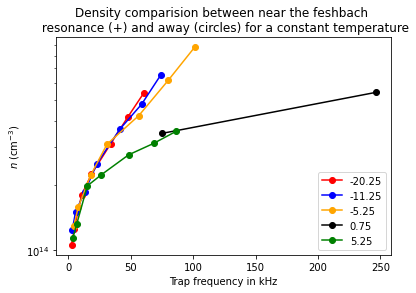

In [43]:
plt.figure()
i = 0

for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['density_constantT'], color = colors[i], marker = 'o', label = latticeDetuning)
    plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['density_constantT'], color = colors[i], marker = '+')
    i += 1
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel(r'$n$ (cm$^{-3}$)')
plt.title('Density comparision between near the feshbach \n resonance (+) and away (circles) for a constant temperature')
plt.savefig('density.jpg', dpi = 300, transparent = False)
plt.show()

We can also do the version where we take the initial temperature of each run

## With temperature measurements

In [44]:
results['density_temperature'] = results['N0']/numberOfPancakes*prefactor/(results['temperature_nK']*nK)*trapFrequenciesProduct*cm3  # in atoms / cm3
results['beta_temperature'] = results['gamma']/ms* results['N0']**2 * np.sqrt(27) / results['density_temperature']**2    # this is is cm^6/s
#results['beta_temperature_limit'] = 2*18/(results['N0']**3)* results['N0']**2 * np.sqrt(27) / results['density_temperature']**2
# gamma = 2b/N0**3 and I plugged 18 s-1 as the vacuum limit. Why did I write that?
results['beta_temperature_limit'] = (1/50)*np.sqrt(27)/results['density_temperature']**2 
# at initial time -b = 1/(18 seconds) = -beta*<n^2> = -beta*n^2/sqrt(27)

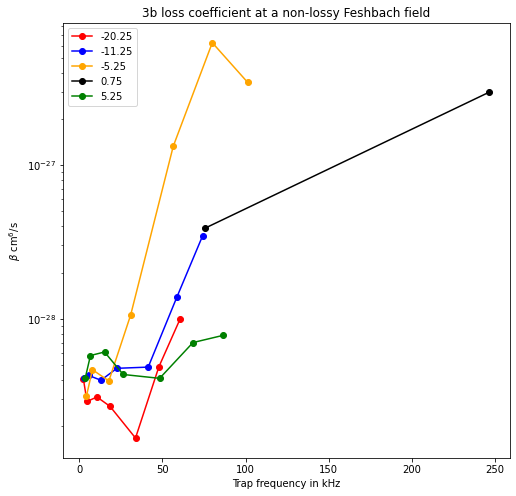

In [45]:
plt.figure(figsize = (8,8))
i = 0

for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    if not (decay_lossy.empty and decay_notlossy.empty):
        plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['beta_temperature'], color = colors[i], marker = 'o', label = latticeDetuning)
        plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['beta_temperature'], color = colors[i], marker = '+')
        #plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['beta_temperature_limit'], 'o', color = 'steelblue', label = "vacuum limit not lossy")
        #plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['beta_temperature_limit'], '+', color = 'steelblue', label = "vacuum limit lossy")
    i += 1
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel(r'$\beta$ cm$^6/$s')
#plt.title('Comparision between near the feshbach \n resonance (+) and away (circles) with the initial temperature')
plt.title('3b loss coefficient at a non-lossy Feshbach field')
plt.show()

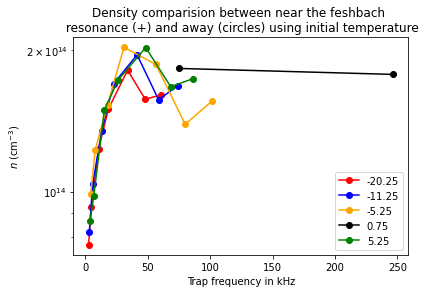

In [46]:
plt.figure()
i = 0

for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.semilogy(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['density_temperature'], color = colors[i], marker = 'o', label = latticeDetuning)
    plt.semilogy(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['density_temperature'], color = colors[i], marker = '+')
    i += 1
plt.legend()
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel(r'$n$ (cm$^{-3}$)')
plt.title('Density comparision between near the feshbach \n resonance (+) and away (circles) using initial temperature')
plt.savefig('density.jpg', dpi = 300, transparent = False)
plt.show()

In [47]:
results.head()

,N0,alpha,gamma,b,TOF,latticeDepth_mW,latticeDetuning_GHz,compz,ODT3_Comp_final,ODT12_pre_lattice,...,xWidth,yWidth,imageID,temperature_nK,effectiveTrapFrequencyZ_kHz,density_constantT,beta_constantT,density_temperature,beta_temperature,beta_temperature_limit
0,33705.853601,NaN,4.051778e-14,NaN,7.0,0.3,-20.25,7.4,5.0,1.0,...,30.411538,30.680112,181261.125000,822.841134,10.892604,1.056586e+14,2.142538e-29,7.704422e+13,4.029564e-29,1.750781e-29
1,34068.176493,NaN,4.125610e-14,NaN,7.0,1.0,-20.25,7.4,5.0,1.0,...,30.248675,30.603500,181242.375000,813.081429,14.972980,1.255473e+14,1.578532e-29,9.264552e+13,2.898805e-29,1.210774e-29
2,37675.729919,NaN,6.415280e-14,NaN,5.0,5.0,-20.25,7.4,5.0,1.0,...,22.454062,22.925775,182791.875000,876.727571,24.542901,1.804875e+14,1.452534e-29,1.235190e+14,3.101368e-29,6.811523e-30
3,37454.504068,NaN,8.332852e-14,NaN,5.0,15.0,-20.25,7.4,5.0,1.0,...,22.758163,24.596663,182789.000000,899.755415,35.867463,2.250718e+14,1.199062e-29,1.500886e+14,2.696423e-29,4.613348e-30
4,36781.986994,NaN,7.854544e-14,NaN,5.0,50.0,-20.25,7.4,5.0,1.0,...,24.343214,28.324100,182688.714286,1030.115100,56.283955,3.115836e+14,5.687534e-30,1.814847e+14,1.676459e-29,3.155235e-30


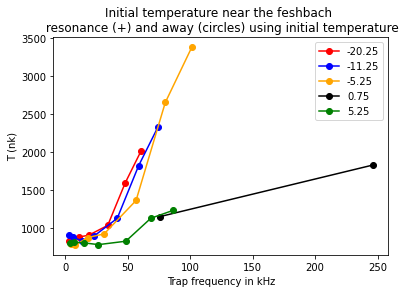

In [48]:
plt.figure()
i = 0

for latticeDetuning in latticeDetuningList:
    decay_notlossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    decay_lossy = getSubDF(results, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.plot(decay_notlossy['trapFrequencyZ_kHz'], decay_notlossy['temperature_nK'], color = colors[i], marker = 'o', label = latticeDetuning)
    plt.plot(decay_lossy['trapFrequencyZ_kHz'], decay_lossy['temperature_nK'], color = colors[i], marker = '+')
    i += 1
plt.legend()
#plt.ylim(0, 1000)
#plt.xlim(0,20)
plt.xlabel('Trap frequency in kHz')
plt.ylabel(r'T (nk)')
plt.title('Initial temperature near the feshbach \n resonance (+) and away (circles) using initial temperature')
plt.savefig('density.jpg', dpi = 300, transparent = False)
plt.show()

In [68]:
latticeDepthList

array([  0.3,   1. ,   5. ,  15. ,  50. , 100. , 160. ])

In [49]:
results.columns

Index(['N0', 'alpha', 'gamma', 'b', 'TOF', 'latticeDepth_mW',
       'latticeDetuning_GHz', 'compz', 'ODT3_Comp_final', 'ODT12_pre_lattice',
       'ODT3_pre_lattice', 'nCount', 'xPos', 'yPos', 'isotope',
       'xWidth_TOF_h_um', 'zWidth_TOF_h_um', 'trapFrequencyZ_kHz',
       'deconfiningTrapFrequency_Hz', 'bareTrapFrequencyX_Hz',
       'bareTrapFrequencyY_Hz', 'bareTrapFrequencyZ_Hz', 'trapFrequencyX_Hz',
       'trapFrequencyY_Hz', 'BECHoldTime', 'dummy', 'xWidth', 'yWidth',
       'imageID', 'temperature_nK', 'effectiveTrapFrequencyZ_kHz',
       'density_constantT', 'beta_constantT', 'density_temperature',
       'beta_temperature', 'beta_temperature_limit'],
      dtype='object')

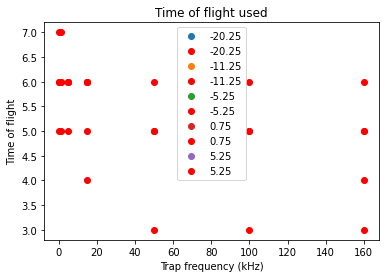

In [50]:
# Plot of the time constant
plt.figure()
for latticeDetuning in latticeDetuningList:
    results_temp = getSubDF(resultsDF_pure, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_lossy])
    plt.plot(results_temp['latticeDepth_mW'], results_temp['TOF'], 'o', label = latticeDetuning)
    results_temp = getSubDF(resultsDF_pure, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    plt.plot(results_temp['latticeDepth_mW'], results_temp['TOF'], 'o', label = latticeDetuning, color = 'red')
plt.legend()
plt.title('Time of flight used')
plt.xlabel('Trap frequency (kHz)')
plt.ylabel('Time of flight')
#plt.ylim(0,80)
plt.show()

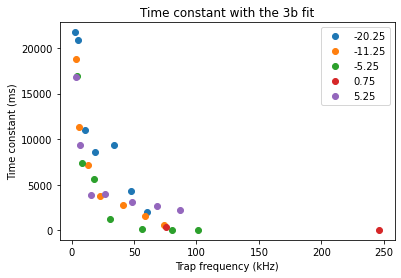

In [51]:
# Plot of the time constant
plt.figure()
for latticeDetuning in latticeDetuningList:
    results_temp = getSubDF(resultsDF_pure, ['latticeDetuning_GHz', 'compz'], [latticeDetuning, compz_not_lossy])
    plt.plot(results_temp['trapFrequencyZ_kHz'], 1/(results_temp['N0']**2*results_temp['gamma']), 'o', label = latticeDetuning)
plt.legend()
plt.title('Time constant with the 3b fit')
plt.xlabel('Trap frequency (kHz)')
plt.ylabel('Time constant (ms)')
#plt.ylim(0,80)
plt.show()

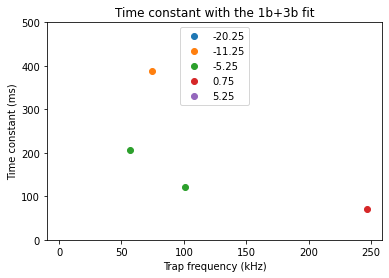

In [52]:
# Plot of the time constant
plt.figure()
for latticeDetuning in latticeDetuningList:
    results_temp = getSubDF(resultsDF_mix, ['latticeDetuning_GHz'], [latticeDetuning])
    plt.plot(results_temp['trapFrequencyZ_kHz'], 1/(results_temp['N0']**2*results_temp['gamma']), 'o', label = latticeDetuning)
plt.legend()
plt.title('Time constant with the 1b+3b fit')
plt.xlabel('Trap frequency (kHz)')
plt.ylabel('Time constant (ms)')
plt.ylim(0,500)
plt.show()

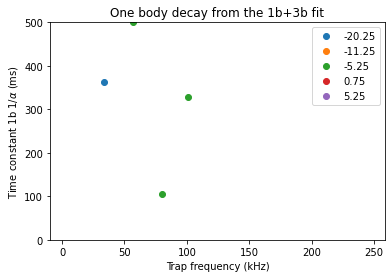

In [53]:
# Plot of the time constant
plt.figure()
for latticeDetuning in latticeDetuningList:
    results_temp = getSubDF(resultsDF_mix, ['latticeDetuning_GHz'], [latticeDetuning])
    plt.plot(results_temp['trapFrequencyZ_kHz'], 1/results_temp['alpha'], 'o', label = latticeDetuning)
plt.legend()
plt.title('One body decay from the 1b+3b fit')
plt.xlabel('Trap frequency (kHz)')
plt.ylabel(r'Time constant 1b $1/\alpha$ (ms)')
plt.ylim(0,500)
plt.show()

Adiabatic criterion. What is the real one?

Blue case: the smallest radial trap frequencies are about 200Hz with ODT3Comp = 5. Which means about 0.5ms should be fine and still adiabatic for the $z$ direction (starts at 3kHz). This trap frequency remains in the vicinity and might diminish to ~100Hz. It's best to be too fast than too slow in order not to change the temperature measurement.

Red case: smallest depends on the ODTFactor, but taking -20GHz and 0.2mW with ODTFactor = 4 we have 140Hz in X and 60Hz in Y. Agains starting at 0.5ms sounds good. -1GHz 120mW will be closer to 2kHz trap frequency while the Z is 300kHz, so 10 $\mu$s is good there.

A good formula would be $500\mu$s constant in the blue case and then noticing that $100$mW and -2GHz gives about 240kHz trap frequency, which is suitable for 10$\mu$s ramping time, then something that goes inversly propotionnal to $\sqrt{\frac{P/100}{\Delta/2}}$ is good. You want to saturate at 500$\mu$s at 0 power so:
\[\tau = max\left(\frac{10 \mu s}{\frac{10}{500} + \sqrt{\frac{P/100}{\Delta/2}}}, 10\mu s\right)\]

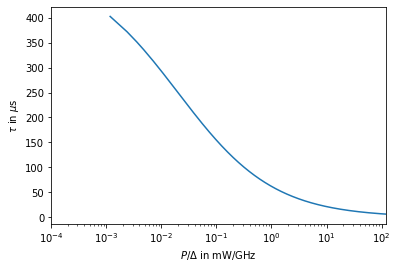

In [54]:
X = np.linspace(0.1/85, 120, 100000)   # X = P/Delta
Y = 10/(10/500+np.sqrt(X/50))
plt.figure()
plt.semilogx(X, Y)
plt.ylabel(r'$\tau$ in $\mu$s')
plt.xlabel(r'$P/\Delta$ in mW/GHz')
plt.xlim(0.0001, 120)
plt.show()

## Temperature plots

In [55]:
latticeDepth = 1
latticeDetuning = -11.25
compz = compz_not_lossy
df_tempZ = getSubDF(df, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])
time = np.linspace(0, 3000, 10000)

In [56]:
df_tempZ[['nCount', 'temperature_nK', 'BECHoldTime']]

,nCount,temperature_nK,BECHoldTime
0,28950.0,914.743065,200.0
1,19103.0,1728.133326,20000.0
2,41651.0,1021.245124,200.0
3,20809.0,1602.586232,15000.0
4,34349.0,1371.603284,5000.0
5,20494.0,1460.230594,15000.0
6,43435.0,875.434950,0.0
7,39046.0,1160.911009,1000.0
8,40015.0,877.846406,0.0
9,34974.0,1470.370616,5000.0


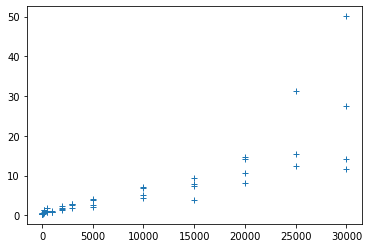

In [57]:
plt.figure()
plt.plot(df_tempZ['BECHoldTime'], df_tempZ['temperature_nK']**3/df_tempZ['nCount']**2, '+')
# I should actually correct for the density
plt.show()

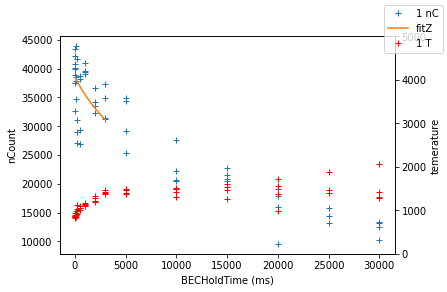

"\n# Create some mock data\nt = np.arange(0.01, 10.0, 0.01)\ndata1 = np.exp(t)\ndata2 = np.sin(2 * np.pi * t)\n\n\ncolor = 'tab:red'\nax1.set_xlabel('time (s)')\nax1.set_ylabel('exp', color=color)\nax1.plot(t, data1, color=color)\nax1.tick_params(axis='y', labelcolor=color)\n\nax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis\n\ncolor = 'tab:blue'\nax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1\nax2.plot(t, data2, color=color)\nax2.tick_params(axis='y', labelcolor=color)\n\nfig.tight_layout()  # otherwise the right y-label is slightly clipped\nplt.show()"

In [58]:
resultZ = getSubDF(resultsDF_pure, ['latticeDepth_mW', 'latticeDetuning_GHz', 'compz'], [latticeDepth, latticeDetuning, compz])

NZ, gammaZ = resultZ[['N0', 'gamma']].iloc[0,:]
Z = N_polarized_pure3b(time, NZ, gammaZ)

fig, ax1 = plt.subplots()
ax1.set_xlabel('BECHoldTime (ms)')
ax1.set_ylabel('nCount')
ax1.plot(df_tempZ['BECHoldTime'], df_tempZ['nCount'], '+', label = str(round(latticeDepth, 2)) + " nC")
ax1.plot(time, Z, '-', label = 'fitZ')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('temerature')  # we already handled the x-label with ax1
ax2.plot(df_tempZ['BECHoldTime'], df_tempZ['temperature_nK'], '+', color = 'red', label = str(round(latticeDepth, 2)) + ' T')
ax2.set_ylim(0,5000)
fig.legend()
#fig.tight_layout()
#plt.ylim(0, 20000)
#plt.xlim(0,10)

plt.show()

"""
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)


color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()"""

In [59]:
df_tempZ[df_tempZ['temperature_nK'] < 250].iloc[:,10:35]

,xWidth,yWidth,xPos,yPos,imageID,isotope,run,xWidth_TOF_h_um,zWidth_TOF_h_um,trapFrequencyZ_kHz,deconfiningTrapFrequency_Hz,bareTrapFrequencyX_Hz,bareTrapFrequencyY_Hz,bareTrapFrequencyZ_Hz,trapFrequencyX_Hz,trapFrequencyY_Hz,temperature_nK


Calculate the velocity to temperature conversion. Here $\sigma = \sqrt{\sigma_0^{2}+(\sigma_{v}t)^{2}}$ is fitted from a gaussian distribution $\exp(-\frac{1}{2}\frac{x^{2}}{\sigma^{2}})$ where $x = vt$, so $v$ is distributed like a gaussian with width $\sigma_{v}$ which is the result of the fit $P(v) \sim \exp(-\frac{1}{2}\frac{v^{2}}{\sigma_{v}^{2}}) \sim \exp(-\frac{\frac{1}{2}mv^{2}}{k_{B}T})$. Therefore we find:
\[ \sigma_{v} = \sqrt{\frac{k_{B}T}{m}}\]

In [60]:
m_Dy = 164*1.66*10**(-27)
k_B = 1.38*10**(-23)
#pixel_size = 6.5*10**(-6)   ### Define that globally
tof_unit = 10**(-3)
#magnification = 3
resultsDF_sigma['temperature_Z'] = m_Dy*(resultsDF_sigma['v_Z']*pixel_size/magnification/tof_unit)**2/k_B
resultsDF_sigma['temperature_trans'] = m_Dy*(resultsDF_sigma['v_trans']*pixel_size/magnification/tof_unit)**2/k_B
resultsDF_sigma

NameError: name 'resultsDF_sigma' is not defined